# Clustering (Dbscan) & Nearest Neighbors (ANNOY)

The goal is to first cluster the data points into several clusters (DBSCAN) and then find nearest neighbors within the cluster using ANNOY, thus combining the strengh of both algorithms.

**Why DBSCAN?**
* Unlike K-means, No need to specify the number of clusters.
* More robust to noise and outliers: it can detect and label them as separate points during the clustering process. We suspect different densities and shapes in our dataset which reinforces the choice for DBSCAN.
* Less sensitive to the order of input data: As a result, the clustering outcome remains relatively stable even if the input data order is changed.


**Why ANNOY?**

The advantage of Annoy is its ability to efficiently find approximate nearest neighbors in high-dimensional spaces. It uses trees and hashing techniques to index the data points, allowing for fast queries compared to a linear search. Annoy is particularly useful for a large dataset (>100 000 data points) and situations where there is a need to find the nearest neighbors for a query point without having to compare it with every data point (less time of prediction)

As a high-performant nearest neigbor algrithm, ANNOY combined with DBSCAN gives 2 major benefits:
* Faster nearest neighbor search: By building an Annoy index for each cluster, we  perform nearest neighbor searches within a specific cluster rather than the entire dataset, which is much faster.

* Better recommendations results: By searching for nearest neighbors within a cluster, we find more relevant results, as the data points within the same cluster are more similar to each other.

Moreover, based on benchamrking of nearest neigbors algorithms, ANNOY does relatively good job as measured by Recall queries per second (1/s) trade-off. 
(https://github.com/erikbern/ann-benchmarks)

**Important:** About the dataset & Goal of this notebook: The goal is to explore the association (e.g. using clustering) between users behaviors to create "segments" of users based on the kind of songs they listen to. In this case, a cluster would represent a set of users who listen to similiar songs. The dataset includes hundreds of user songs history.

In [4]:
import pandas as pd
import numpy as np
from annoy import AnnoyIndex
import psycopg2
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import plotly.express as px
import psycopg2
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [ ]:
DATABASE_URL = DATABASE_URL = os.environ['DATABASE_URL']
conn = psycopg2.connect(DATABASE_URL, sslmode='require')

# Read data from the database using a SQL query
df = pd.read_sql_query("SELECT * FROM user_track_df LIMIT 80000 ", conn)

# Don't forget to close the connection when you're done
conn.close()

<ipython-input-4-2445b98bf42f>:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("SELECT * FROM user_track_df LIMIT 80000 ", conn)


In [ ]:
df.shape

(80000, 24)

In [ ]:
df.head()

,user_id,song_id,listen_count,track_id,artist_name,track_name,track_uri,popularity,duration_ms,explicit,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artist_id
0,f159b77baa49cfc720114b9228ebbeb4d874772f,SOVGPYM12AB01859A1,5,TRKDCXK12903CC27D8,Gloria Gaynor,I Will Survive,7rIovIsXE6kMn629b7kDig,58,296107,0,...,-9.571,0,0.0495,0.02270,0.002620,0.297,0.802,116.935,4,6V6WCgi7waF55bJmylC4H5
1,f159b77baa49cfc720114b9228ebbeb4d874772f,SOWPASM12A8C142B88,2,TRSSPPR128F92C3A4E,The Pussycat Dolls,When I Grow Up,21pySLskKIKrhDziCX5ojQ,74,245680,0,...,-5.762,0,0.0500,0.00165,0.000000,0.398,0.368,118.449,4,6wPhSqRtPu1UhRCDX5yaDJ
2,f159b77baa49cfc720114b9228ebbeb4d874772f,SOWYYUQ12A6701D68D,3,TRVVTWQ128E078F1B7,Bon Jovi,It's My Life,0v1XpBHnsbkCn7iJ9Ucr1l,80,224493,0,...,-4.063,0,0.0466,0.02630,0.000013,0.347,0.544,119.992,4,58lV9VcRSjABbAbfWS6skp
3,f159b77baa49cfc720114b9228ebbeb4d874772f,SOXKVWC12A6701FB97,1,TRUIATC128EF343580,Black Eyed Peas,Bebot,4nZwaKTdxczLpUHfLVAozA,46,210200,0,...,-6.289,0,0.3790,0.24200,0.000000,0.660,0.628,106.893,4,1yxSLGMDHlW21z4YXirZDS
4,f159b77baa49cfc720114b9228ebbeb4d874772f,SOZDGEW12A8C13E748,4,TRMLBEG128F42BA124,Metallica,One,5IX4TbIR5mMHGE4wiWwKW0,72,447440,0,...,-9.447,1,0.0617,0.00111,0.085700,0.124,0.413,102.178,3,2ye2Wgw4gimLv2eAKyk1NB


In [ ]:
#We need only numerical columns for DBSCAN
df_numeric = df.select_dtypes(include=np.number)
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   listen_count      80000 non-null  int64  
 1   popularity        80000 non-null  int64  
 2   duration_ms       80000 non-null  int64  
 3   explicit          80000 non-null  int64  
 4   danceability      80000 non-null  float64
 5   energy            80000 non-null  float64
 6   key               80000 non-null  int64  
 7   loudness          80000 non-null  float64
 8   mode              80000 non-null  int64  
 9   speechiness       80000 non-null  float64
 10  acousticness      80000 non-null  float64
 11  instrumentalness  80000 non-null  float64
 12  liveness          80000 non-null  float64
 13  valence           80000 non-null  float64
 14  tempo             80000 non-null  float64
 15  time_signature    80000 non-null  int64  
dtypes: float64(9), int64(7)
memory usage: 9.

In [ ]:
# Transforming release_ date into separate columns
df_numeric[["year", "month", "day"]] = df["release_date"].str.split("-", expand=True)
df_numeric["day"]=pd.to_numeric(df_numeric["day"])
df_numeric["month"]=pd.to_numeric(df_numeric["month"])
df_numeric ["year"]=pd.to_numeric(df_numeric ["year"])

In [ ]:
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   listen_count      80000 non-null  int64  
 1   popularity        80000 non-null  int64  
 2   duration_ms       80000 non-null  int64  
 3   explicit          80000 non-null  int64  
 4   danceability      80000 non-null  float64
 5   energy            80000 non-null  float64
 6   key               80000 non-null  int64  
 7   loudness          80000 non-null  float64
 8   mode              80000 non-null  int64  
 9   speechiness       80000 non-null  float64
 10  acousticness      80000 non-null  float64
 11  instrumentalness  80000 non-null  float64
 12  liveness          80000 non-null  float64
 13  valence           80000 non-null  float64
 14  tempo             80000 non-null  float64
 15  time_signature    80000 non-null  int64  
 16  year              80000 non-null  int64 

In [ ]:
print("Percentage of null values for 'month' column", (df_numeric.month.isnull().sum()/len(df_numeric))*100)
print("Percentage of null values for 'day' column", (df_numeric.day.isnull().sum()/len(df_numeric))*100)

Percentage of null values for 'month' column 13.468749999999998
Percentage of null values for 'day' column 13.642499999999998


In [ ]:
#Fill null values with median
df_numeric.fillna(df.median(numeric_only=True).round(1), inplace=True)
df_numeric.fillna({"day": df_numeric['day'].median(), 
                   "month": df_numeric['month'].median()}, 
                  inplace=True)

###DBSCAN

In [ ]:
# Preprocessing and scaling the data (assuming df_kmeans is your DataFrame)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_numeric)

# Define a range of eps values and a list of min_samples values
eps_values = np.arange(0.1, 1.0, 0.1)
min_samples_values = list(range(1, 11))

In [ ]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# Initialize variables to store the best parameters and the highest silhouette score
best_eps = None
best_min_samples = None
highest_silhouette_score = -1

# Create an empty list to store silhouette scores for each combination of eps and min_samples
silhouette_scores = []

# Finding Hyperparameters — Iterate through the combinations of eps and min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        # Perform DBSCAN clustering with the current combination of parameters
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(scaled_data)
        
        # Calculate the silhouette score, ignoring the noise points (label -1)
        if len(set(dbscan_labels)) > 1 and -1 in set(dbscan_labels):
            silhouette_avg = silhouette_score(scaled_data, dbscan_labels, metric='euclidean')
            silhouette_scores.append([eps, min_samples, silhouette_avg])
            print(f"eps: {eps}, min_samples: {min_samples}, silhouette score: {silhouette_avg}")
            
            # Update the best parameters and highest silhouette score if necessary
            if silhouette_avg > highest_silhouette_score:
                best_eps = eps
                best_min_samples = min_samples
                highest_silhouette_score = silhouette_avg

print(f"Best parameters: eps = {best_eps}, min_samples = {best_min_samples}")
print(f"Highest silhouette score: {highest_silhouette_score}")

# Convert the silhouette scores to a DataFrame
silhouette_df = pd.DataFrame(silhouette_scores, columns=['eps', 'min_samples', 'silhouette'])

eps: 0.1, min_samples: 2, silhouette score: 0.6585665829399667
eps: 0.1, min_samples: 3, silhouette score: 0.47808772682953105
eps: 0.1, min_samples: 4, silhouette score: 0.36646220461803797
eps: 0.1, min_samples: 5, silhouette score: 0.270276742788606
eps: 0.1, min_samples: 6, silhouette score: 0.20335141285495187
eps: 0.1, min_samples: 7, silhouette score: 0.13790986163449312
eps: 0.1, min_samples: 8, silhouette score: 0.09807757363197912
eps: 0.1, min_samples: 9, silhouette score: 0.05824486365379256
eps: 0.1, min_samples: 10, silhouette score: 0.02364699454063114
eps: 0.2, min_samples: 2, silhouette score: 0.6866002020247817
eps: 0.2, min_samples: 3, silhouette score: 0.6021808354280146
eps: 0.2, min_samples: 4, silhouette score: 0.5355718175088293
eps: 0.2, min_samples: 5, silhouette score: 0.47719278387537606
eps: 0.2, min_samples: 6, silhouette score: 0.43377788981867116
eps: 0.2, min_samples: 7, silhouette score: 0.3858055407857758
eps: 0.2, min_samples: 8, silhouette score: 0.

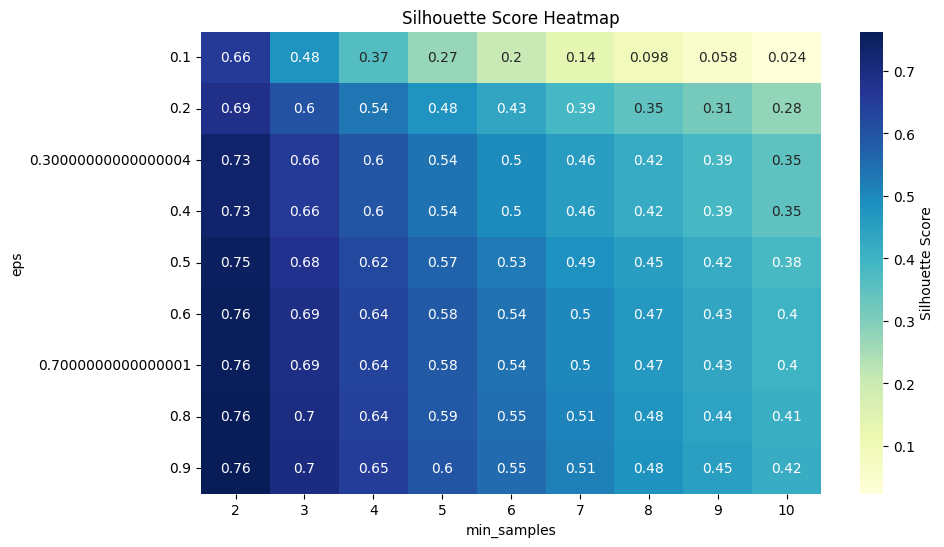

In [ ]:
# Create a heatmap to visualize the silhouette scores
plt.figure(figsize=(10, 6))
sns.heatmap(silhouette_df.pivot("eps", "min_samples", "silhouette"), cmap="YlGnBu", annot=True, cbar_kws={'label': 'Silhouette Score'})
plt.xlabel("min_samples")
plt.ylabel("eps")
plt.title("Silhouette Score Heatmap")
plt.show()

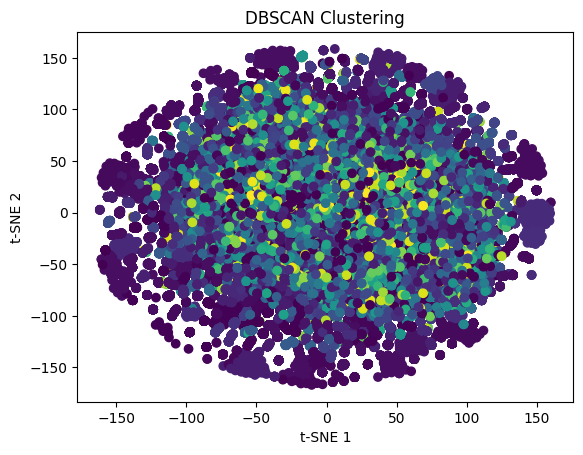

In [ ]:
#Visulization for the case with the best parameters

# Preprocessing and scaling the data (assuming df_kmeans is your DataFrame)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_numeric)

# Perform DBSCAN clustering based on the best hyperparameters
dbscan = DBSCAN(eps=0.9, min_samples=2)
dbscan_labels = dbscan.fit_predict(scaled_data)

# Reduce dimensionality to 2D using t-SNE
tsne = TSNE(n_components=2)
reduced_data = tsne.fit_transform(scaled_data)

# Visualize DBSCAN clusters
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=dbscan_labels, cmap='viridis')
plt.title("DBSCAN Clustering")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

In [ ]:
# Visualize DBSCAN clusters using Plotly
fig = px.scatter(x=reduced_data[:, 0], y=reduced_data[:, 1], color=dbscan_labels,
                 labels={'x': 't-SNE 1', 'y': 't-SNE 2'},
                 color_continuous_scale='Viridis',
                 title="DBSCAN Clustering")
fig.show()

Silhouette Score of **0.76 is approximately 25% improvement from K-means clustering** (based on expriments run in the notebook in this repository)

## ANNOY 

Run nearest neighbor within the cluster produced by DBSCAN.

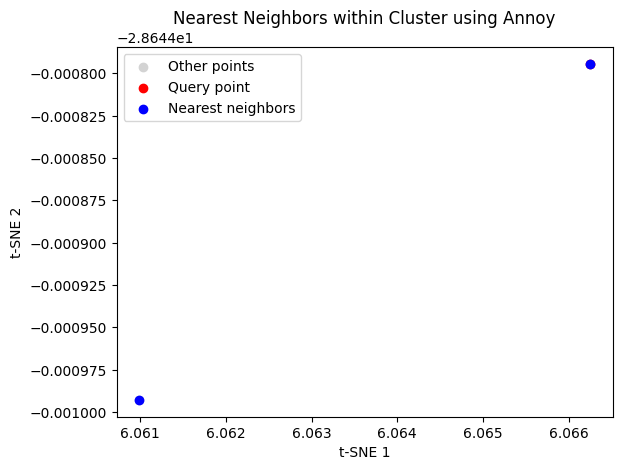

In [ ]:
# Choose a cluster number
cluster_number = 1

# Get data points belonging to the chosen cluster
cluster_data = scaled_data[dbscan_labels == cluster_number]
reduced_cluster_data = reduced_data[dbscan_labels == cluster_number]

# Create an Annoy index
n_dimensions = len(cluster_data[0])
annoy_index = AnnoyIndex(n_dimensions, 'angular')

# Add the filtered data points to the index
for i, row in enumerate(cluster_data):
    annoy_index.add_item(i, row)

# Build the index
n_trees = 10
annoy_index.build(n_trees)

# Choose a query point within the cluster
query_point_index = 0
query_point = cluster_data[query_point_index]

# Find nearest neighbors for the query point within the cluster
n_neighbors = 5
nearest_neighbors = annoy_index.get_nns_by_vector(query_point, n_neighbors)

# Visualize the results
plt.scatter(reduced_cluster_data[:, 0], reduced_cluster_data[:, 1], c='lightgray', label='Other points')
plt.scatter(reduced_cluster_data[query_point_index, 0], reduced_cluster_data[query_point_index, 1], c='red', label='Query point')
plt.scatter(reduced_cluster_data[nearest_neighbors, 0], reduced_cluster_data[nearest_neighbors, 1], c='blue', label='Nearest neighbors')

plt.title("Nearest Neighbors within Cluster using Annoy")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.show()

#### Run ANNOY on the whole dataset, not individual clusters.

In [ ]:
# Preprocessing and scaling the data (assuming df_kmeans is your DataFrame)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_numeric)

# Reduce dimensionality to 2D using t-SNE
tsne = TSNE(n_components=2)
reduced_data = tsne.fit_transform(scaled_data)

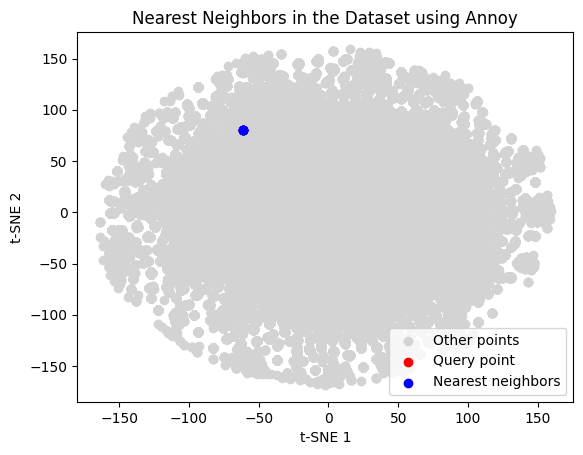

In [ ]:
# Create an Annoy index
n_dimensions = len(scaled_data[0])
annoy_index = AnnoyIndex(n_dimensions, 'angular')

# Add the data points to the index
for i, row in enumerate(scaled_data):
    annoy_index.add_item(i, row)

# Build the index
n_trees = 10
annoy_index.build(n_trees)

# Choose a query point
query_point_index = 0
query_point = scaled_data[query_point_index]

# Find nearest neighbors for the query point
n_neighbors = 5
nearest_neighbors = annoy_index.get_nns_by_vector(query_point, n_neighbors)

# Visualize the results
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c='lightgray', label='Other points')
plt.scatter(reduced_data[query_point_index, 0], reduced_data[query_point_index, 1], c='red', label='Query point')
plt.scatter(reduced_data[nearest_neighbors, 0], reduced_data[nearest_neighbors, 1], c='blue', label='Nearest neighbors')

plt.title("Nearest Neighbors in the Dataset using Annoy")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.show()


## Checking Performance
Calculate time and performance level. We do it by calculating the Recall (proportion of true nearest neighbors found in the search results). We obtain the ground truth by running an exhaustive search (using scikit-learn's NearestNeighbors with the brute algorithm).

In [ ]:
from sklearn.neighbors import NearestNeighbors
import time

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_numeric)

# Create an Annoy index
dim = len(scaled_data[0])
index = AnnoyIndex(dim, 'euclidean')

# Insert the data points into the index
for i, point in enumerate(scaled_data):
    index.add_item(i, point)

# Build the index
n_trees = 10
index.build(n_trees)

# Ground truth: Exhaustive search using scikit-learn's NearestNeighbors
nn = NearestNeighbors(n_neighbors=n_neighbors, algorithm='brute', metric='euclidean')
nn.fit(scaled_data)

# Choose a query point
query_point_index = 0
query_point = scaled_data[query_point_index]

# Time Annoy search
start_time = time.time()
labels = index.get_nns_by_vector(query_point, n_neighbors, include_distances=False)
annoy_time = time.time() - start_time

# Time exhaustive search
start_time = time.time()
true_distances, true_labels = nn.kneighbors(query_point.reshape(1, -1))
exhaustive_time = time.time() - start_time

# Calculate recall
recall = len(np.intersect1d(labels, true_labels[0])) / n_neighbors

print(f"Recall: {recall:.2f}")
print(f"Annoy query time: {annoy_time:.6f} seconds")
print(f"Exhaustive query time: {exhaustive_time:.6f} seconds")


Recall: 1.00
Annoy query time: 0.000185 seconds
Exhaustive query time: 0.005821 seconds
